# Accern: Alpha One

In this notebook, we'll take a look at Accern's *Alpha One* dataset, available on [Quantopian](https://www.quantopian.com/store). This dataset spans August 26, 2012 through the current day. It contains comprehensive sentiment analysis related to equities from 20 million+ sources.

## Notebook Contents

There are two ways to access the data and you'll find both of them listed below. Just click on the section you'd like to read through.

- <a href='#interactive'><strong>Interactive overview</strong></a>: This is only available on Research and uses blaze to give you access to large amounts of data. Recommended for exploration and plotting.
- <a href='#pipeline'><strong>Pipeline overview</strong></a>: Data is made available through pipeline which is available on both the Research & Backtesting environment. Recommended for custom factor development and moving back & forth between research/backtesting.

### Free samples and limits
One key caveat: we limit the number of results returned from any given expression to 10,000 to protect against runaway memory usage. To be clear, you have access to all the data server side. We are limiting the size of the responses back from Blaze.

There is a *free* version of this dataset as well as a paid one. The free sample includes data until 2 months prior to the current date.

To access the most up-to-date values for this data set for trading a live algorithm (as with other partner sets), you need to purchase acess to the full set.

With preamble in place, let's get started:

<a id='interactive'></a>
#Interactive Overview
### Accessing the data with Blaze and Interactive on Research
Partner datasets are available on Quantopian Research through an API service known as [Blaze](http://blaze.pydata.org). Blaze provides the Quantopian user with a convenient interface to access very large datasets, in an interactive, generic manner.

Blaze provides an important function for accessing these datasets. Some of these sets are many millions of records. Bringing that data directly into Quantopian Research directly just is not viable. So Blaze allows us to provide a simple querying interface and shift the burden over to the server side.

It is common to use Blaze to reduce your dataset in size, convert it over to Pandas and then to use Pandas for further computation, manipulation and visualization.

Helpful links:
* [Query building for Blaze](http://blaze.readthedocs.io/en/latest/queries.html)
* [Pandas-to-Blaze dictionary](http://blaze.readthedocs.io/en/latest/rosetta-pandas.html)
* [SQL-to-Blaze dictionary](http://blaze.readthedocs.io/en/latest/rosetta-sql.html).

Once you've limited the size of your Blaze object, you can convert it to a Pandas DataFrames using:
> `from odo import odo`  
> `odo(expr, pandas.DataFrame)`


###To see how this data can be used in your algorithm, search for the `Pipeline Overview` section of this notebook or head straight to <a href='#pipeline'>Pipeline Overview</a>

In [15]:
# import the dataset
from quantopian.interactive.data.accern import alphaone_free as dataset

# or if you want to import the paid dataset, use:
# from quantopian.interactive.data.accern import alphaone

# import data operations
from odo import odo
# import other libraries we will use
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Let's use blaze to understand the data a bit using Blaze dshape()
dataset.dshape

dshape("""var * {
  symbol: string,
  name: ?string,
  article_sentiment: float64,
  impact_score: float64,
  sid: int64,
  asof_date: datetime,
  timestamp: datetime
  }""")

In [4]:
# And how many rows are there?
# N.B. we're using a Blaze function to do this, not len()
dataset.count()

591697

In [5]:
# Let's see what the data looks like. We'll grab the first three rows.
dataset[:3]

,symbol,name,article_sentiment,impact_score,sid,asof_date,timestamp
0,AAPL,Apple Inc.,-0.194,70.495,24,2012-08-26,2012-08-26
1,GRPN,"Groupon, Inc.",-0.167,79.000,42118,2012-08-26,2012-08-26
2,TWTR,"Twitter, Inc.",-0.473,29.362,19171,2012-08-26,2012-08-26


Let's go over the columns:
- **symbol**: the ticker symbol of the company.
- **name**: the name of the company.
- **asof_date**: Alpha One's timestamp of delivery of **article_sentiment**.
- **article_sentiment**: a score in [-1,1] reflecting the sentiment of articles written about the company in the last day. The higher score, the more positive the outlook.
- **timestamp**: this is our timestamp on when we registered the data.
- **impact_score**: on [0,100], this is the probability that the stock price will change by more than 1% (given by: close - open / open) on the next trading day.
- **sid**: the equity's unique identifier. Use this instead of ticker or name. 

We've done much of the data processing for you. Fields like `timestamp` and `sid` are standardized across all our Store Datasets, so the datasets are easy to combine. We have standardized the `sid` across all our equity databases.

We can select columns and rows with ease. Below, we'll fetch all entries for the sid 24, which identifies AAPL. We're really only interested in the timestamp, article sentiment, and the impact score, so we'll display only those.

In [7]:
aapl = dataset[dataset.sid==24][['asof_date','article_sentiment', 'impact_score']].sort('asof_date')
# Whenever you print a Blaze Data Object, it will be truncated to ten rows.
aapl

,asof_date,article_sentiment,impact_score
0,2012-08-26,-0.194,70.495
1,2012-08-27,-0.126,70.086
2,2012-08-28,-0.367,70.100
3,2012-08-29,-0.219,70.436
4,2012-08-30,-0.071,70.738
5,2012-08-31,-0.167,70.417
6,2012-09-01,-0.392,71.379
7,2012-09-02,-0.270,70.664
8,2012-09-03,-0.320,70.570
9,2012-09-04,-0.361,70.746


You can see that Accern collects data for every day, not just for every business day.

Let's convert `aapl` to a DataFrame.

In [10]:
aapl_sentiment = odo(aapl, pd.DataFrame)
# let's say we only want one year of data.
aapl_sentiment = aapl_sentiment[aapl_sentiment['asof_date'] <= '2013-08-26']
# suppose we want the rows to be indexed by timestamp.
aapl_sentiment.index = list(aapl_sentiment['asof_date'])
aapl_sentiment.drop('asof_date',1,inplace=True)
# display the first three rows. DataFrames, when printed, display 60 rows at a time.
aapl_sentiment[:3]

,article_sentiment,impact_score
2012-08-26,-0.194,70.495
2012-08-27,-0.126,70.086
2012-08-28,-0.367,70.100


Let's take a look at the sentiment in a chart

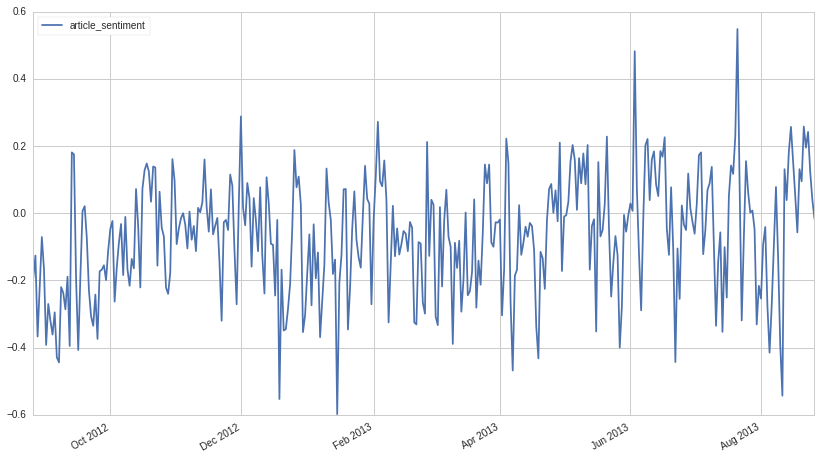

In [11]:
aapl_sentiment.plot(y='article_sentiment')

<a id='pipeline'></a>

#Pipeline Overview

### Accessing the data in your algorithms & research
The only method for accessing partner data within algorithms running on Quantopian is via the pipeline API. Different data sets work differently but in the case of this PsychSignal data, you can add this data to your pipeline as follows:

Import the data set here
> `from quantopian.pipeline.data.accern import alphaone`

Then in intialize() you could do something simple like adding the raw value of one of the fields to your pipeline:
> `pipe.add(alphaone.impact_score.latest, 'impact_score')`

In [1]:
# Import necessary Pipeline modules
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import AverageDollarVolume

In [2]:
# For use in your algorithms
# Using the full paid dataset in your pipeline algo
# from quantopian.pipeline.data.accern import alphaone

# Using the free sample in your pipeline algo
from quantopian.pipeline.data.accern import alphaone_free

Now that we've imported the data, let's take a look at which fields are available for each dataset.

You'll find the dataset, the available fields, and the datatypes for each of those fields.

In [3]:
print "Here are the list of available fields per dataset:"
print "---------------------------------------------------\n"

def _print_fields(dataset):
    print "Dataset: %s\n" % dataset.__name__
    print "Fields:"
    for field in list(dataset.columns):
        print "%s - %s" % (field.name, field.dtype)
    print "\n"

for data in (alphaone_free,):
    _print_fields(data)


print "---------------------------------------------------\n"

Here are the list of available fields per dataset:
---------------------------------------------------

Dataset: alphaone_free

Fields:
article_sentiment - float64
impact_score - float64


---------------------------------------------------



Now that we know what fields we have access to, let's see what this data looks like when we run it through Pipeline.


This is constructed the same way as you would in the backtester. For more information on using Pipeline in Research view this thread:
https://www.quantopian.com/posts/pipeline-in-research-build-test-and-visualize-your-factors-and-filters

In [4]:
# Let's see what this data looks like when we run it through Pipeline
# This is constructed the same way as you would in the backtester. For more information
# on using Pipeline in Research view this thread:
# https://www.quantopian.com/posts/pipeline-in-research-build-test-and-visualize-your-factors-and-filters
pipe = Pipeline()

pipe.add(alphaone_free.impact_score.latest, 'impact_score')
pipe.add(alphaone_free.article_sentiment.latest, 'article_sentiment')

In [5]:
# Setting some basic liquidity strings (just for good habit)
dollar_volume = AverageDollarVolume(window_length=20)
top_1000_most_liquid = dollar_volume.rank(ascending=False) < 1000

pipe.set_screen(top_1000_most_liquid & alphaone_free.article_sentiment.latest.notnan())

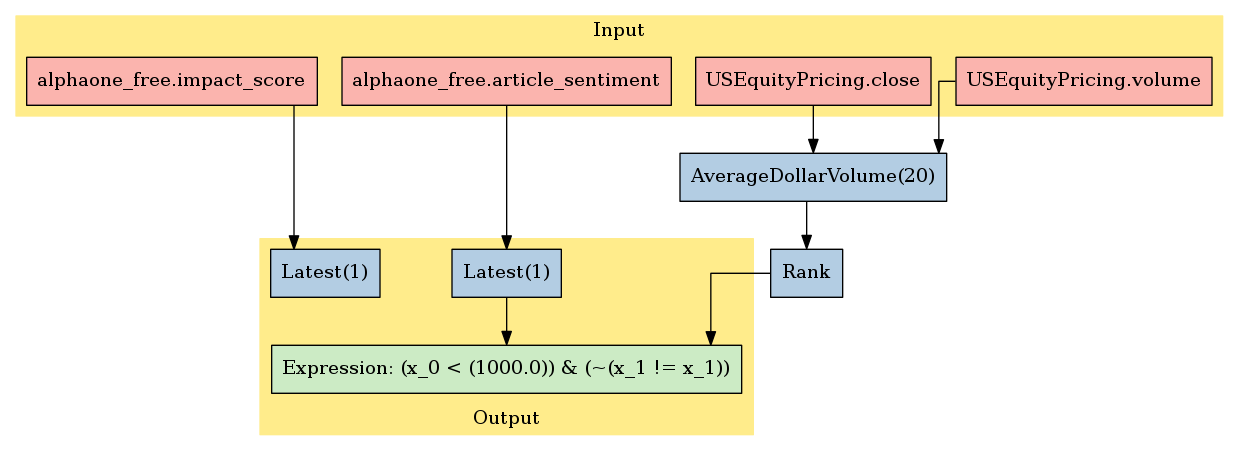

In [6]:
# The show_graph() method of pipeline objects produces a graph to show how it is being calculated.
pipe.show_graph(format='png')

In [7]:
# run_pipeline will show the output of your pipeline
pipe_output = run_pipeline(pipe, start_date='2013-11-01', end_date='2013-11-25')
pipe_output

article_sentiment  \
2013-11-01 00:00:00+00:00 Equity(2 [AA])                    0.000   
                          Equity(24 [AAPL])                 0.001   
                          Equity(62 [ABT])                 -0.392   
                          Equity(64 [ABX])                  0.000   
                          Equity(67 [ADSK])                 1.000   
                          Equity(76 [TAP])                 -1.000   
                          Equity(88 [ACI])                 -0.190   
                          Equity(114 [ADBE])               -0.341   
                          Equity(122 [ADI])                 0.000   
                          Equity(128 [ADM])                -0.333   
                          Equity(154 [AEM])                 0.000   
                          Equity(161 [AEP])                 0.000   
                          Equity(166 [AES])                 0.000   
                          Equity(168 [AET])                 0.708   
                          Equity(185 [AFL])                -0.405   
                          Equity(197 [AGCO])                1.000   
                          Equity(216 [HES])                 0.500   
                          Equity(239 [AIG])                 0.083   
                          Equity(273 [ALU])                 0.000   
                          Equity(300 [ALK])                 0.000   
                          Equity(328 [ALTR])                0.000   
                          Equity(337 [AMAT])                1.000   
                          Equity(351 [AMD])                -0.061   
                          Equity(353 [AME])                 0.000   
                          Equity(357 [TWX])                 0.000   
                          Equity(368 [AMGN])                0.000   
                          Equity(410 [AN])                  0.000   
                          Equity(438 [AON])                 0.000   
                          Equity(448 [APA])                 0.000   
                          Equity(455 [APC])                 0.714   
...                                                           ...   
2013-11-25 00:00:00+00:00 Equity(42950 [FB])                0.358   
                          Equity(43127 [NOW])               1.000   
                          Equity(43399 [ADT])              -1.000   
                          Equity(43405 [KRFT])              0.000   
                          Equity(43413 [TRLA])              1.000   
                          Equity(43414 [SRC])               0.000   
                          Equity(43500 [RLGY])              0.000   
                          Equity(43510 [WDAY])              0.000   
                          Equity(43512 [FANG])             -1.000   
                          Equity(43647 [YY])               -1.000   
                          Equity(43694 [ABBV])              0.000   
                          Equity(43721 [SCTY])             -0.500   
                          Equity(43919 [LMCA])             -1.000   
                          Equity(44060 [ZTS])               0.000   
                          Equity(44102 [XONE])              0.000   
                          Equity(44645 [VOYA])              1.000   
                          Equity(44747 [DATA])              0.000   
                          Equity(44931 [NWSA])              0.000   
                          Equity(44965 [GOGO])             -1.000   
                          Equity(45656 [GLPI])              0.000   
                          Equity(45689 [VJET])              0.000   
                          Equity(45755 [BRX])               0.000   
                          Equity(45769 [WUBA])              0.000   
                          Equity(45780 [TCS])               1.000   
                          Equity(45781 [QUNR])             -1.000   
                          Equity(45815 [TWTR])             -0.043   
                          Equity(45848 [STAY])

Taking what we've seen from above, let's see how we'd move that into the backtester.

In [11]:
# This section is only importable in the backtester
from quantopian.algorithm import attach_pipeline, pipeline_output

# General pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import AverageDollarVolume

# Import the datasets available
# For use in your algorithms
# Using the full paid dataset in your pipeline algo
# from quantopian.pipeline.data.accern import alphaone

# Using the free sample in your pipeline algo
from quantopian.pipeline.data.accern import alphaone_free

def make_pipeline():
    # Create our pipeline
    pipe = Pipeline()
    
    # Screen out penny stocks and low liquidity securities.
    dollar_volume = AverageDollarVolume(window_length=20)
    is_liquid = dollar_volume.rank(ascending=False) < 1000
    
    # Create the mask that we will use for our percentile methods.
    base_universe = (is_liquid)

    # Add pipeline factors
    pipe.add(alphaone_free.impact_score.latest, 'impact_score')
    pipe.add(alphaone_free.article_sentiment.latest, 'article_sentiment')

    # Set our pipeline screens
    pipe.set_screen(is_liquid)
    return pipe

def initialize(context):
    attach_pipeline(make_pipeline(), "pipeline")
    
def before_trading_start(context, data):
    results = pipeline_output('pipeline')

Now you can take that and begin to use it as a building block for your algorithms, for more examples on how to do that you can visit our <a href='https://www.quantopian.com/posts/pipeline-factor-library-for-data'>data pipeline factor library</a>